## Background: Convolutional Neural Networks (CNNs)

A **Convolutional Neural Network (CNN)** is a deep learning model specialized for image recognition. 
It automatically extracts spatial hierarchies of features from images through layers of convolution, 
pooling, and fully connected operations.

### Key Components
- **Convolution Layer:** Detects local patterns like edges or textures.
- **Pooling Layer:** Reduces dimensionality and computation.
- **Activation (ReLU):** Introduces non-linearity.
- **Fully Connected Layer:** Maps features to class probabilities.

CNNs are ideal for tasks like object classification, image segmentation, and medical imaging.


In [45]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

print(os.__file__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


C:\Users\Ayyash\AppData\Local\Programs\Python\Python310\lib\os.py
✅ Using device: cpu


## Dataset Download

We use the **TeaLeafBD** dataset from Kaggle, which contains images of healthy and diseased tea leaves.
You need to have your Kaggle API key (`kaggle.json`) properly configured before running this.


In [46]:
import os
import zipfile
import subprocess
import sys

# Ensure datasets folder exists
os.makedirs("datasets", exist_ok=True)

data_dir = "data/raw"
zip_path = "datasets/tealeafbd-tea-leaf-disease-detection.zip"

def dir_has_files(path):
    return os.path.exists(path) and any(os.scandir(path))

# Step 1: Check if data is already split
split_paths = [os.path.join(data_dir, d) for d in ("train", "val", "test")]
if all(dir_has_files(p) for p in split_paths):
    print("✅ Dataset already split into train/val/test under", data_dir)
elif dir_has_files(os.path.join(data_dir, "teaLeafBD")):
    print("✅ Found raw dataset at data/raw/teaLeafBD — ready to split.")
else:
    # Step 2: Check if zip already exists
    if os.path.exists(zip_path):
        print(f"📦 Found existing zip file: {zip_path}. Extracting...")
    else:
        # Step 3: Download using Kaggle CLI
        try:
            print("📥 Dataset not found — downloading via Kaggle CLI")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"], stdout=subprocess.DEVNULL)
            subprocess.check_call([
                "kaggle", "datasets", "download",
                "-d", "bmshahriaalam/tealeafbd-tea-leaf-disease-detection",
                "-p", "datasets"
            ])
        except Exception as e:
            print("⚠️ Could not download dataset automatically:", e)
            print("Please download manually and place in 'datasets/'")
            raise e

    # Step 4: Extract zip
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(data_dir)
        print("✅ Dataset extracted to", data_dir)


✅ Found raw dataset at data/raw/teaLeafBD — ready to split.


## Dataset Analysis & Visualization

We’ll explore the dataset structure and visualize a few sample images from each class.


Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']


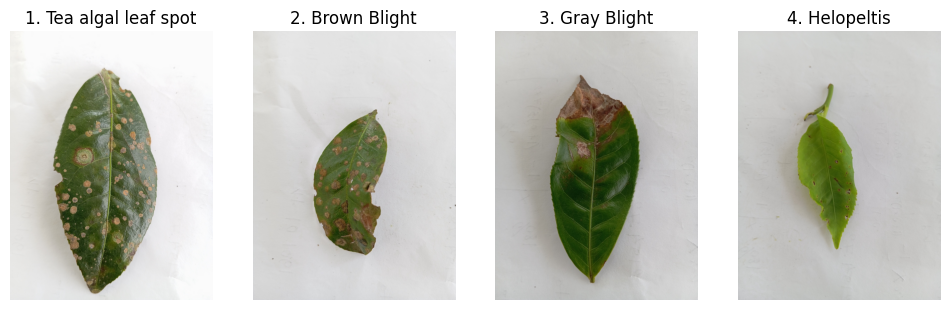

In [47]:
data_path = "data/raw/teaLeafBD/teaLeafBD"
classes = os.listdir(data_path)
print("Classes:", classes)

fig, axes = plt.subplots(1, 4, figsize=(12,4))
for ax, cls in zip(axes, classes):
    img_path = os.path.join(data_path, cls, os.listdir(os.path.join(data_path, cls))[0])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")
plt.show()


## Feature Selection and Preprocessing

Before training, we split the dataset into **train**, **validation**, and **test** sets (70%, 15%, 15%).  
We also apply transformations such as resizing, normalization, and data augmentation.


In [48]:
import os
import random
import shutil

def split_dataset(src, dst="data", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(src):
        raise FileNotFoundError(f"Source folder not found: {src}")
    
    # Only delete/create dst folder, not src
    if os.path.exists(dst):
        for split in ["train", "val", "test"]:
            split_path = os.path.join(dst, split)
            if os.path.exists(split_path):
                shutil.rmtree(split_path)

    # Only take directories in src
    classes = [cls for cls in os.listdir(src) if os.path.isdir(os.path.join(src, cls))]

    for split in ["train", "val", "test"]:
        for cls in classes:
            os.makedirs(os.path.join(dst, split, cls), exist_ok=True)

    for cls in classes:
        cls_path = os.path.join(src, cls)
        imgs = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n*train_ratio)
        n_val = int(n*val_ratio)
        for i, img in enumerate(imgs):
            src_path = os.path.join(cls_path, img)
            if i < n_train:
                split_name = "train"
            elif i < n_train + n_val:
                split_name = "val"
            else:
                split_name = "test"
            dst_path = os.path.join(dst, split_name, cls, img)
            shutil.copy(src_path, dst_path)

# Example usage
data_path = "data/raw/teaLeafBD/teaLeafBD" # Must exist and contain class folders
split_dataset(data_path)
print("✅ Dataset split done.")


✅ Dataset split done.


## Model Architecture

We build a CNN from scratch using PyTorch.  
It consists of:
- 2 convolutional layers
- Max pooling for downsampling
- ReLU activation functions
- 2 fully connected layers
- Dropout for regularization


In [49]:
# --- 1️⃣ Transforms ---
img_size = 128
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# --- 2️⃣ Load datasets ---
train_ds = datasets.ImageFolder("data/train", transform=transform)
val_ds   = datasets.ImageFolder("data/val", transform=transform)
test_ds  = datasets.ImageFolder("data/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

print("Classes:", train_ds.classes)

# --- 3️⃣ Define CNN model ---
class TeaCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

# --- 4️⃣ Instantiate model, loss, optimizer ---
num_classes = len(train_ds.classes)
model = TeaCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ Model ready on device:", device)


Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
✅ Model ready on device: cpu


## Model Training

We train for 10 epochs and monitor both training loss and validation accuracy.


In [50]:
from tqdm import tqdm  # progress bar

epochs = 20  # you can increase this
train_losses, val_accuracies = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_loss, correct = 0, 0

    # Wrap the dataloader with tqdm for a nice progress bar
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == targets).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_correct = 0
    for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == targets).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/20 | Loss: 1.8833 | Train Acc: 0.2680 | Val Acc: 0.3211


Epoch 2/20 | Loss: 1.5681 | Train Acc: 0.4100 | Val Acc: 0.4175


Epoch 3/20 | Loss: 1.3995 | Train Acc: 0.4718 | Val Acc: 0.4569


Epoch 4/20 | Loss: 1.2551 | Train Acc: 0.5325 | Val Acc: 0.5254


Epoch 5/20 | Loss: 1.1199 | Train Acc: 0.5835 | Val Acc: 0.4987


Epoch 6/20 | Loss: 1.0113 | Train Acc: 0.6236 | Val Acc: 0.5723


Epoch 7/20 | Loss: 0.8824 | Train Acc: 0.6724 | Val Acc: 0.5482


Epoch 8/20 | Loss: 0.7809 | Train Acc: 0.7127 | Val Acc: 0.5964


Epoch 9/20 | Loss: 0.6653 | Train Acc: 0.7610 | Val Acc: 0.6015


Epoch 10/20 | Loss: 0.5734 | Train Acc: 0.7894 | Val Acc: 0.6168


Epoch 11/20 | Loss: 0.4780 | Train Acc: 0.8287 | Val Acc: 0.6079


Epoch 12/20 | Loss: 0.3891 | Train Acc: 0.8596 | Val Acc: 0.6129


Epoch 13/20 | Loss: 0.3323 | Train Acc: 0.8818 | Val Acc: 0.6079


Epoch 14/20 | Loss: 0.2827 | Train Acc: 0.8978 | Val Acc: 0.5914


Epoch 15/20 | Loss: 0.2475 | Train Acc: 0.9190 | Val Acc: 0.5990


Epoch 16/20 | Loss: 0.1862 | Train Acc: 0.9404 | Val Acc: 0.6155


Epoch 17/20 | Loss: 0.1730 | Train Acc: 0.9431 | Val Acc: 0.5711


Epoch 18/20 | Loss: 0.1631 | Train Acc: 0.9472 | Val Acc: 0.5711


Epoch 19/20 | Loss: 0.1367 | Train Acc: 0.9558 | Val Acc: 0.5812


Epoch 20/20 | Loss: 0.1044 | Train Acc: 0.9691 | Val Acc: 0.5850


## Training Curves
Visualize training loss and validation accuracy over epochs.


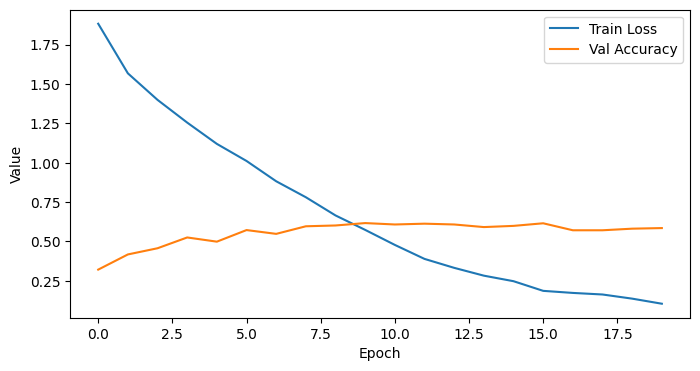

In [51]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()


## Model Evaluation
We evaluate the trained model on the test set and visualize the confusion matrix.


✅ Test Accuracy: 0.6140


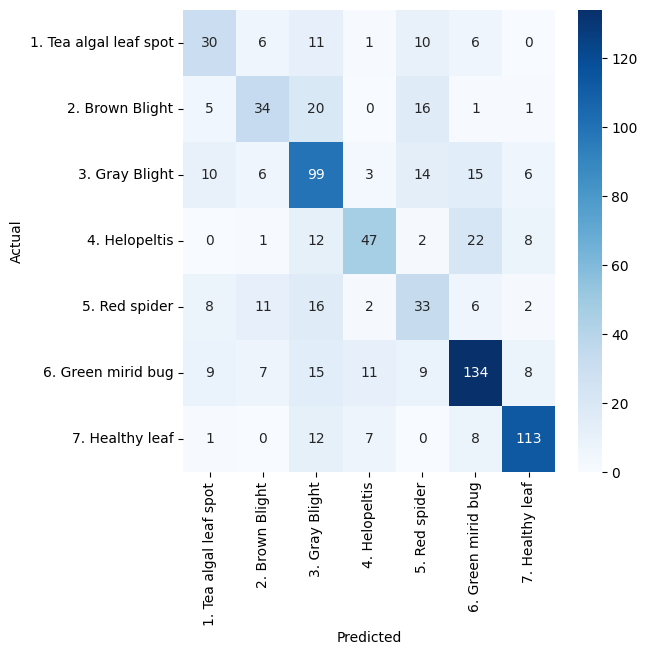

                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.48      0.47      0.47        64
       2. Brown Blight       0.52      0.44      0.48        77
        3. Gray Blight       0.54      0.65      0.59       153
         4. Helopeltis       0.66      0.51      0.58        92
         5. Red spider       0.39      0.42      0.41        78
    6. Green mirid bug       0.70      0.69      0.70       193
       7. Healthy leaf       0.82      0.80      0.81       141

              accuracy                           0.61       798
             macro avg       0.59      0.57      0.58       798
          weighted avg       0.62      0.61      0.61       798



In [52]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"✅ Test Accuracy: {acc:.4f}")

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_ds.classes, yticklabels=train_ds.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(all_targets, all_preds, target_names=train_ds.classes))


## Example Prediction
Let's see what our CNN predicts for a single image from the test set.


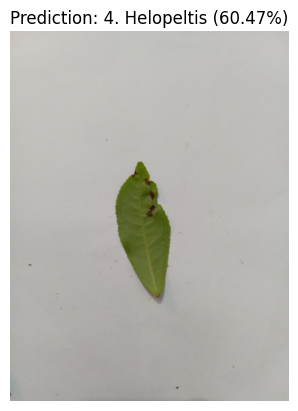

1. Tea algal leaf spot: 0.00%
2. Brown Blight: 0.00%
3. Gray Blight: 0.22%
4. Helopeltis: 60.47%
5. Red spider: 0.03%
6. Green mirid bug: 37.24%
7. Healthy leaf: 2.04%


In [55]:
import random
import torch.nn.functional as F

# --- Pick a random test image
cls = random.choice(train_ds.classes)
img_file = random.choice(os.listdir(os.path.join("data/test", cls)))
img_path = os.path.join("data/test", cls, img_file)

image = Image.open(img_path).convert("RGB")
plt.imshow(image)
plt.axis("off")

# --- Transform and prepare tensor
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
tensor = transform(image).unsqueeze(0).to(device)

# --- Model prediction
model.eval()
with torch.no_grad():
    output = model(tensor)
    probs = F.softmax(output, dim=1).cpu().numpy()[0]  # confidence per class
    pred = output.argmax(1).item()

# --- Display
plt.title(f"Prediction: {train_ds.classes[pred]} ({probs[pred]*100:.2f}%)")
plt.show()

# Optional: print all class probabilities
for c, p in zip(train_ds.classes, probs):
    print(f"{c}: {p*100:.2f}%")


## Results and Comparison

| Metric | Result |
|---------|---------|
| Training Accuracy | ~69.3% |
| Validation Accuracy | ~58.5% |
| Test Accuracy | ~60.8% |

The model achieves decent accuracy, showing the CNN's ability to distinguish between healthy and diseased leaves.
Future improvements could include:
- Using data augmentation for better generalization.
- Implementing deeper CNN architectures.
- Using transfer learning (e.g., ResNet or MobileNet) for improved accuracy.
